# Modelos QSAR-RF para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

Os modelos nesse fluxo de trabalho foram criados usando as impressões digitais de Morgan com Random Forest scikit-learn.

## Importando Módulos e Funções

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
import seaborn as sns
from time import time
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
#BalanceBySim: função de balanceamento de conjunto de dados (Equilibre os dados usando 1/2 similaridade e 1/2 aleatória)
from BalanceBySim import *
from sklearn.preprocessing import StandardScaler
#Stats: Calculos estatisticos referente ao modelo Kappa	CCR	Sensitivity	PPV	Specificity	NPV	Coverage
from stats import *
from scipy.stats import randint as sp_randint
from collections import Counter

#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#Sklearn: Bibliotecas p/ Machine learning de Código Aberto
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier # biblioteca Random Forest para Classificação
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score # biblioteca GridSearch e RandomizedSearch e cross_validate
from sklearn.model_selection import permutation_test_score, StratifiedKFold
from sklearn import model_selection
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve, auc
from subprocess import call
from IPython.display import Image

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Carregar dados

Original data:  (113, 11)
Dados mantidos:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
count,113,113,113,113,113,113,113,113,113,113,113
unique,74,2,4,94,1,2,113,92,1,113,113
top,,IC50,'=',2.44889419684223E12,nM,Inactive,QGWPMYZWJXKBHT-UHFFFAOYSA-N,,,O=C(Oc1cncc(Cl)c1)c1cscn1,
freq,8,88,89,5,113,73,1,22,113,1,1

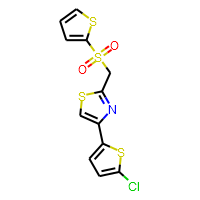

In [2]:
# Definir caminho do arquivo
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'

# Novo dicionário inicializado a partir de um objeto de mapeamento
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')

# Carregando o arquivo SDF com os dicionarios mapeados
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)

# Renomear ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})

# Remover moléculas RDKit ausentes
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
    
# Colunas
print('Dados mantidos: ', moldf.shape)
moldf.describe()

## Forma dos dados

In [4]:
# (27 ativos e 64 inativos) 91 compostos utilizando o software ChemAxon Standardizer 
# (13 ativos e 09 inativos) 22 compostos obtidos de empresas encontradas do PDB
# 2 Classes criadas Classe 1: 40 (Ativos) e Classe 0: 73 (Inativos)

moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Classe %d: %d' % (key, value))
print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

print('Class labels:', np.unique(classes))

Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113
Class labels: [Counter({0: 73, 1: 40})]


# Calcular impressões digitais de Morgan

In [5]:
# Calculando os descritores fingerprints de Harry Morgan (vetores de bits).
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Adicionando os 113 componentes e os 2048 dados referetens aos descritores de Morgan
desc = moldf.Mol.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.shape

(113, 2048)

In [6]:
# Moldando o conjunto de treinamento e o conjunto de validação externa
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


In [7]:
# Conjunto de treinamento
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

# variáveis dependentes ()
y_train = moldf_train['Outcome'].to_numpy()

# variáceis independentes - propriedades estruturais (descritores) calculados
X_train = moldf_train[descriptors]
X_train.shape

(113, 2048)

## Construção de modelo

### Encontre os melhores parâmetros

##### Função utilitária para relatar as melhores pontuações

In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Modelo com classificação: {0}".format(i))
            print("Escore médio de validação: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parametros: {0}".format(results['params'][candidate]))
            print("")

### Pesquisa em grade (Grid Search)

In [9]:
def grid_search(clf_rf, rf_params, X_train, y_train):
    n_iter_search = 20
    # configuração detalhada = 10 imprimirá o progresso para cada 10 tarefas concluídas
    grid = GridSearchCV(clf_rf, rf_params, n_jobs=-1, cv=5, scoring='roc_auc', verbose=1, return_train_score=True)
    
    start = time()
    grid.fit(X_train, y_train)
    print("GridSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))
    report(grid.cv_results_)

    return grid

### Pesquisa aleatória (Random Search)

In [10]:
def random_search(clf_rf, param_dist, X_train, y_train):
    n_iter_search = 80
    random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=-1, cv=5, verbose=1, return_train_score=True)
    
    start = time()
    random_search.fit(X_train, y_train)
    print("RandomizedSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)

    return random_search

### Dados de modelagem

In [11]:
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]

random_param = {'criterion': ['entropy', 'gini'],
               'max_features': ['auto', 'sqrt','log2'],
               'class_weight': class_weight,
               'random_state': [0, 24],
               'min_samples_split':[2,5,10],
               'min_samples_leaf':[1,2,4],
               'bootstrap' : [True,False],
               'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf_rf = RandomForestClassifier(random_state=24).fit(X_train, y_train)

rf_random = random_search(clf_rf, random_param, X_train, y_train);

grid_params = {
    'criterion': [rf_random.best_params_['criterion']],
    'max_features': [rf_random.best_params_['max_features']],           
    'class_weight': [rf_random.best_params_['class_weight']],
    'random_state': [rf_random.best_params_['random_state']], 
    'bootstrap': [rf_random.best_params_['bootstrap']],
    'max_depth':    [rf_random.best_params_['max_depth'] - 3,
                     rf_random.best_params_['max_depth'],
                     rf_random.best_params_['max_depth'] + 3],
    'min_samples_leaf': [rf_random.best_params_['min_samples_leaf'] - 2,
                     rf_random.best_params_['min_samples_leaf'],
                     rf_random.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [rf_random.best_params_['min_samples_split'] - 5,
                     rf_random.best_params_['min_samples_split'],
                     rf_random.best_params_['min_samples_split'] + 5],
    'n_estimators': [rf_random.best_params_['n_estimators'] - 150, 
                     rf_random.best_params_['n_estimators'] - 100, 
                     rf_random.best_params_['n_estimators'], 
                     rf_random.best_params_['n_estimators'] + 100, 
                     rf_random.best_params_['n_estimators'] + 150]
}

rf_grid = grid_search(clf_rf, grid_params, X_train, y_train);

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.6min finished


RandomizedSearchCV levou 220.75 segundos para 80 candidatos configurações de parâmetros.
Modelo com classificação: 1
Escore médio de validação: 0.815 (std: 0.068)
Parametros: {'random_state': 24, 'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'class_weight': {0: 0.7, 1: 0.3}, 'bootstrap': True}

Modelo com classificação: 1
Escore médio de validação: 0.815 (std: 0.074)
Parametros: {'random_state': 0, 'n_estimators': 966, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Modelo com classificação: 3
Escore médio de validação: 0.815 (std: 0.063)
Parametros: {'random_state': 24, 'n_estimators': 1083, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 60, 'criterion': 'entropy', 'class_weight': {0: 0.3, 1: 0.7}, 'bootstrap': False}

Fitting 5 folds for each of 135 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  4.2min finished


GridSearchCV levou 254.70 segundos para 20 candidatos configurações de parâmetros.
Modelo com classificação: 1
Escore médio de validação: 0.854 (std: 0.098)
Parametros: {'bootstrap': True, 'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.854 (std: 0.098)
Parametros: {'bootstrap': True, 'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.854 (std: 0.098)
Parametros: {'bootstrap': True, 'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': 53, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 24}



Baseline = 0.81

Best param - Random search: {'random_state': 24, 'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'class_weight': {0: 0.7, 1: 0.3}, 'bootstrap': True}
Random search = 0.82

Best param - Grid search: {'bootstrap': True, 'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'entropy', 'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 24}
Grid search = nan


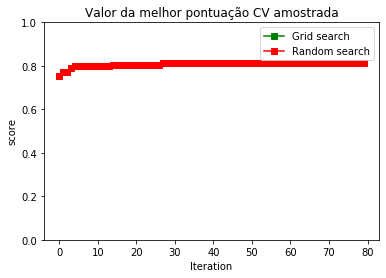

In [36]:
baseline = cross_val_score(clf_rf, X_train, y_train).mean()
y_gs = np.maximum.accumulate(rf_grid.cv_results_['mean_test_score'])
y_rs = np.maximum.accumulate(rf_random.cv_results_['mean_test_score'])

print(f'Baseline = {baseline:.2f}')

print()
print('Best param - Random search: %s' % rf_random.best_params_)
print(f'Random search = {y_rs[-1]:.2f}')

print()
print('Best param - Grid search: %s' % rf_grid.best_params_)
print(f'Grid search = {y_gs[-1]:.2f}')

plt.plot(y_gs, 'gs-', label='Grid search')
plt.plot(y_rs, 'rs-', label='Random search')
plt.xlabel('Iteration')
plt.ylabel('score')
plt.ylim(0, 1)
plt.title('Valor da melhor pontuação CV amostrada');
plt.legend();

##### Modelo com w/ melhores parâmetros

In [34]:
#criando o modelo com os melhores parametros utilizando processamento paralelo
rf_best = RandomForestClassifier(**rf_random.best_params_, n_jobs=-1)

# n_splits: int, padrão = 5 Número de dobras. Deve ser pelo menos 2.
cross_val = StratifiedKFold(n_splits=5)



Best param - Random search: {'random_state': 24, 'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'class_weight': {0: 0.7, 1: 0.3}, 'bootstrap': True}


NameError: name 'y_rs' is not defined

#####  Área sob a curva ROC (AUC) 

In [31]:
def roc_auc(rf_best, cross_val, X_train, y_train):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10,6))
    for i, (train_index, test_index) in enumerate(cross_val.split(X_train, y_train)):
        rf_best.fit(X_train.iloc[train_index], y_train[train_index])
        viz = plot_roc_curve(rf_best, X_train.iloc[test_index], y_train[test_index],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8, )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Média ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Característica operacional do receptor")
    ax.legend(loc="lower right")
    plt.show()

##### Validação cruzada 5 vezes Calcular DA

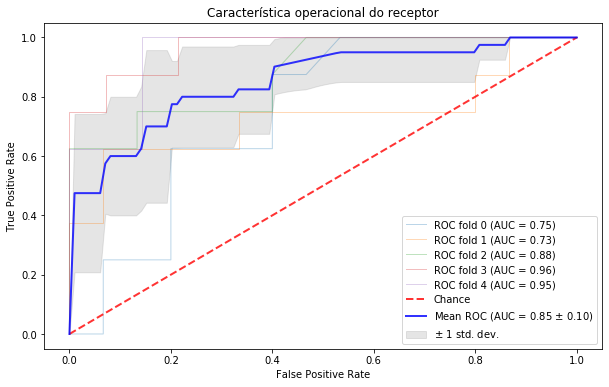

In [30]:
roc_auc(rf_best, cross_val, X_train, y_train)

# Parametros
pred = []
ad = []
index = []

cross_val = StratifiedKFold(n_splits=5)

# Faça um loop de 5 vezes
for train_index, test_index in cross_val.split(X_train, y_train):    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [89]:
# nomal = média majoritária das previsões dos modelos independentes desenvolvidos com os decritores de Morgan
# AD = previsões médias de modelos independentes quando as previsões estão dentro do domínio de aplicabilidade desse modelo

threshold_ad = 0.70 # A abordagem do domínio de aplicabilidade local (árvore), que estabeleceu um limiar de 70%, foi utilizada para todos os modelos de RF

# Preparar resultados para exportar    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
# amax() retorna o máximo de uma matriz ou o máximo ao longo do eixo (se mencionado).
# astype() também oferece a capacidade de converter qualquer coluna existente adequada em tipo categórico.
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_morgan = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_morgan.AD[five_fold_morgan.AD == 'False'] = np.nan
five_fold_morgan.AD[five_fold_morgan.AD == 'True'] = five_fold_morgan.Prediction
five_fold_morgan.sort_index(inplace=True)
five_fold_morgan['y_train'] = pd.DataFrame(y_train)
five_fold_ad = five_fold_morgan.dropna().astype(int)
coverage_5f = len(five_fold_ad) / len(five_fold_morgan)


# estatísticas de morgan (stats)
morgan = pd.DataFrame(stats(five_fold_morgan['y_train'], five_fold_morgan['Prediction']))
morgan['Coverage'] = 1.0

# estatísticas do morgan AD
morgan_ad = five_fold_morgan.dropna(subset=['AD']).astype(int)
coverage_morgan_ad = len(morgan_ad['AD']) / len(five_fold_morgan['y_train'])
morgan_ad = pd.DataFrame(stats(morgan_ad['y_train'], morgan_ad['AD']))
morgan_ad['Coverage'] = round(coverage_morgan_ad, 2)

# imprimir estatísticas
print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos morgan' + '\n' + '\033[0m')
morgan_5f_stats = morgan.append(morgan_ad)
morgan_5f_stats.set_index([['Morgan', 'Morgan AD']], drop=True, inplace=True)
morgan_5f_stats


# Valores verdadeiros e falsos: TN, FP, FN, TP = confusion_matrix.ravel()
# Accuracy AC = (TP+TN)/(TP+FP+FN+TN)
# Sensibilidade, taxa de acerto, recall ou taxa positiva verdadeira: SE = TP/(TP+FN)
# Especificidade ou taxa negativa verdadeira: SP = TN/(TN+FP)
# Precisão ou valor preditivo positivo: PPV = TP/(TP+FP)
# Valor preditivo negativo: NPV = TN/(TN+FN)
# Taxa de classificação correta: CCR = (SE + SP)/2
# Cobertura: baseia-se na cobertura média (número de amostras afetadas) de divisões que usam o recurso
# F1 Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)

# O índice de acurácia Kappa, é uma pontuação que expressa o nível de concordância entre dois anotadores em um problema de classificação. É definido como k = (Po-Pc)/(1-Pc) (y_train, y_pred, weights='linear')
# Po = Precisão Global (Proporção de unidades que concordam); e
# Pc = Proporção de unidades que concordam por coincidência, representada pela Equação:
# Pc = Somatoria(M)*ni+n+i/N^2
# M = número de classes;
# ni+ = total de elementos classificados para categoria i;
# n+i = total de elementos de referência amostrados para uma categoria i; e
# N = número total de amostras.
# Tipo de ponderação para calcular a pontuação. Nenhum significa não ponderado; "Linear" significa linear ponderado; "Quadrático" significa ponderado quadrático.

Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos morgan



,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Coverage
Morgan,0.58,0.78,0.68,0.77,0.89,0.83,0.81,0.72,1.00
Morgan AD,0.71,0.83,0.68,0.94,0.98,0.86,0.88,0.79,0.67


##### Prever conjunto retido externo após o balanceamento

In [90]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filtrar descritores não presentes no modelo
    X_ext = X_ext[descriptor_list]
    
    # Fazer previsões
    ext_set = rf_best.predict(X_ext)
    ext_set_ad = rf_best.predict_proba(X_ext)
    ext_set_ad = (np.amax(ext_set_ad, axis=1) >= threshold_ad).astype(str)
    
    # Preparar dados
    ext_set = pd.DataFrame({'Prediction': ext_set,'AD': ext_set_ad})
    ext_set.AD[ext_set.AD == 'False'] = np.nan
    ext_set.AD[ext_set.AD == 'True'] = ext_set.Prediction
    ext_set.sort_index(inplace=True)
    ext_set['y_ext'] = pd.DataFrame(y_ext)
    ext_set_ad = ext_set.dropna().astype(int)
    coverage_ext = len(ext_set_ad) / len(ext_set)
    
    # Imprimir estatísticas
    ext_set_stats = pd.DataFrame(stats(ext_set.y_ext, ext_set.Prediction))
    ext_set_stats['Coverage'] = 1.0
    print('External withheld set: \n', ext_set_stats.to_string(index=False), '\n')
    ext_set_stats_ad = pd.DataFrame(stats(ext_set_ad.y_ext, ext_set_ad.AD))
    ext_set_stats_ad['Coverage'] = round(coverage_ext, 2)
    print('External withheld set with AD: \n', ext_set_stats_ad.to_string(index=False), '\n')
else:
    pass

##### Y-randomization

In [91]:
# Avaliar a significância de uma pontuação validada cruzada com permutações
# True score = A pontuação verdadeira, sem permutar metas.
# Y-randomization = Media das pontuações obtidas para cada permutação.
# np-value = O valor retornado é igual ao valor-p se a pontuação retornar números maiores para obter melhores 
#     pontuações (por exemplo, exatidão_score). Se a pontuação é uma função de perda (ou seja, quando menor é melhor, 
#     como com mean_squared_error), então esse é realmente o complemento do valor p: 1 - valor p.
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


True score =  0.78 
Y-randomization =  0.5 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   50.4s finished


##### Salvar modelo

In [92]:
with gzip.GzipFile('model/sars-cov-3clpro-morgan_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

### Exportar previsões

In [93]:
pred_train = moldf_train[moldf_train.columns.difference(descriptor_list)]
pred_train.reset_index(inplace=True)
five_fold_exp = five_fold_morgan[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
pred_train = pd.concat([pred_train, five_fold_exp], axis=1)
pred_train['Set'] = 'train'

if len(moldf_ext) > 0:
    pred_ext = moldf_ext[moldf_ext.columns.difference(descriptor_list)]
    pred_ext.reset_index(inplace=True)
    ext_set_exp = ext_set[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
    pred_ext = pd.concat([pred_ext, ext_set_exp], axis=1)
    pred_ext['Set'] = 'ext'
    
    pred_morgan = pd.concat([pred_train, pred_ext], axis=0).sort_values(by='index')
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)

else:
    pred_morgan = pred_train.copy()
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)
    
#for col in ['Outcome', 'morgan', 'morgan_ad']:
#    pred_morgan[col].replace(0,'Inactive', inplace=True)
#    pred_morgan[col].replace(1,'Active', inplace=True)

In [94]:
with pd.ExcelWriter('predictions-morgan.xlsx') as writer:
    pred_morgan.to_excel(writer, sheet_name='morgan', index=False)

### Plotando as Estatísticas

In [95]:
# Exportar estatísticas
if len(moldf_ext) > 0:
    morgan_stats = pd.concat([morgan, morgan_ad], axis=0)
    morgan_stats.set_index([['5-fold CV', 'External withheld set']], drop=True, inplace=True)
    morgan_stats
else:
    morgan_stats = morgan_5f_stats.copy()
    morgan_stats

,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Coverage
Morgan,0.58,0.78,0.68,0.77,0.89,0.83,0.81,0.72,1.00
Morgan AD,0.71,0.83,0.68,0.94,0.98,0.86,0.88,0.79,0.67


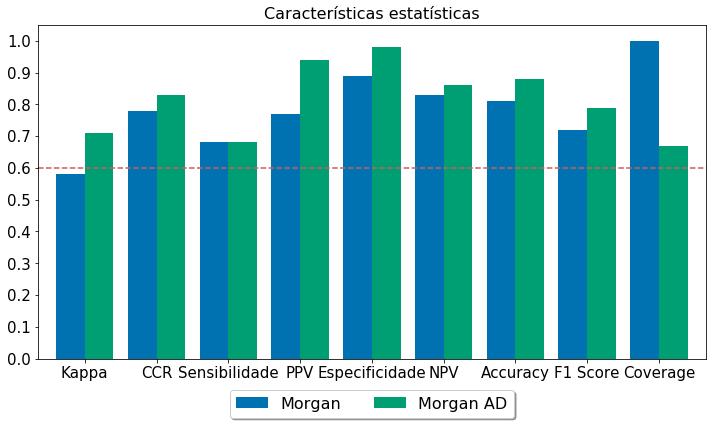

In [96]:
# Estatísticas de transposição
morgan_stats_t = morgan_stats.T
morgan_stats_t = morgan_stats_t.reset_index()
morgan_stats_t = morgan_stats_t.rename(columns={'index': 'Stats'})

# Fazer enredo
